## Method 3: reference distribution based on random sampling, external value for $\sigma$

Let's recall the case study. We have 10 data points for method A and 10 data points for method B.

The means are different: 84.24 for method A vs. 85.54 for method B.

The reference distribution has 210 data points with a mean of 84.12

Question: are 84.24 and 85.54 statistically different based on the reference distribution?

To answer with method 3, we will introduce a new very powerful assumption that each individual observation is as if obtained by random sampling from a normal population with common standard deviation.


In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
pd.set_option('display.max_rows', 500)
y_210 = pd.read_excel('yield 210.xlsx')
y_AB = pd.read_excel('yield 20.xlsx')

### Random sampling from a normal population

Let us understand first a few important results when random sampling from a normal population.

If a random sample of n observations is drawn from a normal distribution with mean $\eta$ and variance $\sigma^2$, then:
1. the distribution of $\bar{y}$ is also normal with mean $\eta$ and variance $\sigma^2/n$
2. the sample variance $s^2$ is distributed independently of $\bar{y}$ in a $\chi^2$ distribution
3. the quantity $(\bar{y} - \eta)/(s/\sqrt{n})$ is distributed with n -1 degrees of freedom in the t distribution

It is the last result 3. that is so powerful as it provides us with a reference distribution to test our sample statistic with all required information coming from from the sample itself! We no longer need an external reference distribution.

[]

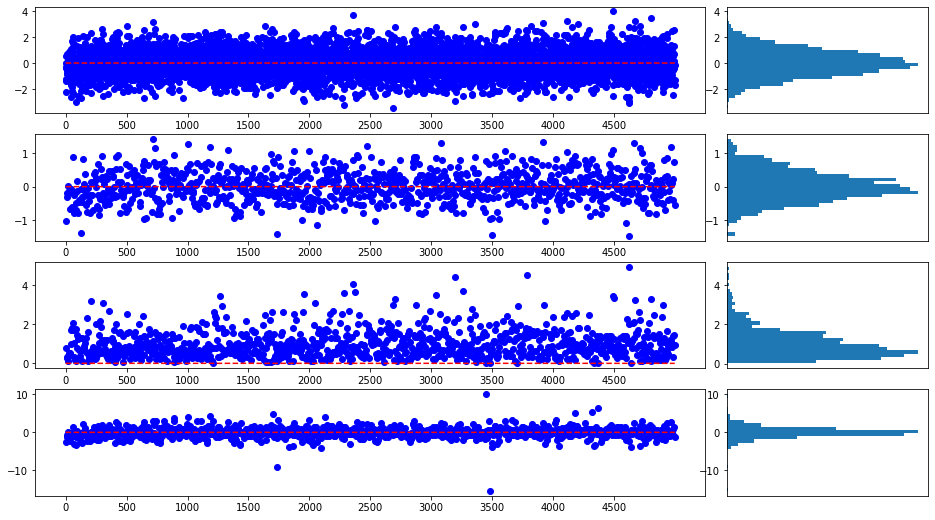

In [2]:
# let's illustrate random sampling from a normal population, taking samples of size n=5 from a normal population
number_of_samples = 1000
n = 5
d_ref = pd.DataFrame(np.random.randn(n,number_of_samples))
y_bar, s_sq, t_d = [], [], []
for column in d_ref:
    m = d_ref[column].mean()
    sq = (1/(n-1))*((d_ref[column] - m)**2).sum()
    t = (m - 0)/math.sqrt(sq/n)
    y_bar.append(m)
    s_sq.append(sq)
    t_d.append(t)

# now printing the result
xtick=number_of_samples/2
fig, axes= plt.subplots(4,2,figsize=(16,9),gridspec_kw={'width_ratios':[2,0.6]})
plt.subplots_adjust(wspace=0.05)
axes[0,0].plot(np.concatenate(d_ref.transpose().to_numpy()),'bo',label='sample data')
axes[0,0].plot([0]*number_of_samples*n,'r--')
axes[0,0].xaxis.set_ticks(np.arange(0,number_of_samples*n,xtick))
axes[0,1].hist(np.concatenate(d_ref.transpose().to_numpy()),orientation='horizontal',bins=30)
axes[0,1].set_xticks([])
# markevery starts at 2 and plots points every 5 number
axes[1,0].plot(np.concatenate([[0,0,i,0,0] for i in y_bar]),'bo',label='y bar',markevery=(2,5))
axes[1,0].plot([0]*number_of_samples*n,'r--')
axes[1,0].xaxis.set_ticks(np.arange(0,number_of_samples*n,xtick))
axes[1,1].hist(y_bar,orientation='horizontal',bins=30)
axes[1,1].set_xticks([])
axes[2,0].plot(np.concatenate([[0,0,i,0,0] for i in s_sq]),'bo',label='s sq',markevery=(2,5))
axes[2,0].plot([0]*number_of_samples*n,'r--')
axes[2,0].xaxis.set_ticks(np.arange(0,number_of_samples*n,xtick))
axes[2,1].hist(s_sq,orientation='horizontal',bins=30)
axes[2,1].set_xticks([])
axes[3,0].plot(np.concatenate([[0,0,i,0,0] for i in t_d]),'bo',label='t',markevery=(2,5))
axes[3,0].plot([0]*number_of_samples*n,'r--')
axes[3,0].xaxis.set_ticks(np.arange(0,number_of_samples*n,xtick))
axes[3,1].hist(t_d,orientation='horizontal',bins=30)
axes[3,1].set_xticks([])

As we can see, the first graph shows the population, nicely bell shaped with 0 mean.

The second graph shows the $\bar{y}$ distsribution which is also bell shaped but narrower, having a variance roughly half the size ($\sqrt{5}$) of that of the parent distribution.

The third graph shows the $\chi^2$ distribution of the variance.

The fourth graph show the t distribution with fatter tails associated with more occurences of lower variance.

### An interesting example of application: the weakness of non-comparative experiments

Equipped with the random sample hypothesis, one natural experiment could be to compare the 85.54 average of method B to the 84.12 average of the reference data using a t statistic.

Basically, what we are saying is that, per the random sampling hypothesis, we have a population or reference data set of 210 points, distributed normally with average 84.12. Under the null hypothesis, the sample taken with method B is just a sample of this population and its sample mean should be compared to 84.12, using a t statistic computed used the sample variance.

However, Box explains this approach introduces a new weakness in our model with a poor design of experiment. The average of batch method B should be compared to an average of batch method A __under similar conditions__.

In that case, the 84.12 average was obtained from 210 points that might have been recorded in conditions that could be quite different from the ones used when recording the 85.54. 

So this approach is not advisable and results below will confirm it provides erroneous results.

In [3]:
# to compute the t statistic, we need y_bar, yo, and s/sqrt(n)
y_bar = 85.54
y0 = 84.12
sq = (1/9)*((y_AB[y_AB['method'] == 'B']['yield']-85.54)**2).sum()
t = (y_bar - y0)/math.sqrt(sq/10)
print('y_bar: {:.02f}, yo: {:.02f}, t: {:.02f}'.format(y_bar,y0,t))
p_value = 1 - st.t.cdf(t,df=9,loc=0,scale=1)
print('p value: {:.02f}'.format(p_value))

y_bar: 85.54, yo: 84.12, t: 1.23
p value: 0.12


As we can see, the p value of 0.12 is not statistically significant (same result could occur by chance 12% of the time) and we cannot reject the null hypothesis based on this calculation.

However, we know from method 1 and method 2 that method B is significantly better than method A so this confirms that, from a poor design of experiment, one can draw incorrect conclusions.

### Back to the industrial experiment: using reference distribution based on sampling model, with an external value for $\sigma$

If we assume now that the 10 yields from method A and method B are each considered as random sample from appropriate populations which share the following characteristics:
- same shape
- same variance $\sigma^2$
- different means $\eta_A$ and $\eta_B$

One can show that the variable $\bar{y_B}-\bar{y_A}$ has a standard deviation equal to $\sigma\sqrt{\frac{1}{n_A}+\frac{1}{n_B}}$ where $\sigma$ can be derived from the 210 points of the reference data.

Let's compute the statistic $z = \frac{(\bar{y_B}-\bar{y_A}) - (\eta_B-\eta_A)}{\sigma\sqrt{1/n_A+1/n_B}}$

In [24]:
# computing the z statistic
ybarB_m_ybarA = 1.30
etaB_m_etaA = 0 # null hypothesis
nA, nB = 10, 10
sigma = math.sqrt((1/209)*((y_210['yield']-84.12)**2).sum())
z = (ybarB_m_ybarA - etaB_m_etaA)/(sigma*math.sqrt(1/nA+1/nB))
p_value2 = 1 - st.norm.cdf(z,loc=0,scale=1)
print('sigma is {:.02f}, z is {:.02f}, p value is {:.03f} '.format(sigma,z,p_value2))

sigma is 2.88, z is 1.01, p value is 0.157 


We notice that the p value of 0.157 is quite different from what was obtained from method 1 (0.047) and 2 (0.028), which did not assume random sampling but used external reference distributions.

The p values obtained from method 1 and 2 allowed us to reject the null hypothesis. The p value from method 3 is too high to reject the null hypothesis. This reveals that the assumption of random sampling, while quite practical, has shortcomings and limitations. In that case, it forces us to reject the null hypothesis which is erroneous based on method 1 and method 2.

It is interesting to notice that the statistic in method 2 and 3 have the same numerator (1.30-0). The difference is that in method 2, we created a new population of differences of averages of consecutive sets of 10 samples and computed the variance of this population. In method 3, we assume there are two populations for method A and B and compute the variance using the 210 data points.